In [1]:
from scipy.io import netcdf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gsw
sns.set(context='talk',style='whitegrid',font_scale=1.3)
#from model_plotting import plot_snapshot,plot_snapshot_w
import scipy.linalg as la
from spectra_module import spec2d

/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
zgrid = pd.read_csv('./psom_data/zgrid.out',skipinitialspace=True,sep=' ',header=None)
zgrid=zgrid[1].values

import glob
dirr = glob.glob('./psom_data/full*')
dirr = dirr[-1]
dirr='./psom_data/full_08325.cdf'
time = dirr.split('/')[2].split('_')[1]

f =  netcdf.netcdf_file(dirr, 'r')
u = f.variables['u'][:][33, 1:321, 1:193]
v= f.variables['v'][:][33, 1:321, 1:193]
vor= f.variables['vor'][:][33, 1:321, 1:193]/gsw.f(17)
xc = f.variables['xc'][1:193]
yc = f.variables['yc'][1:321]

In [4]:
#%%
import random
import math

def make_hex(x0,y0,L,skew):
    i=0
    xx=np.zeros(M)
    yy=np.zeros(M)
    
    degstart = random.randint(0,360)
    angle = np.arange(degstart,degstart+360,360//M)
    angle[angle>360] = angle[angle>360]-360 
    
    random_stretch = random.randint(0,2)
    for j,angle in enumerate( angle ):
        if j==random_stretch:
            alpha=skew
        else:
            alpha=1
        xx[i] = x0 + alpha*L*math.cos(math.radians(angle))
        yy[i] = y0 + alpha*L*math.sin(math.radians(angle))
        i+=1
        
    return xx,yy

def make_n_hexs(L,skew):
    x=np.zeros((N,M))
    y=np.zeros((N,M))
    for i in range(N):
        x0=(180-10)*random.random() + 10
        y0=(300-10)*random.random() + 10
        x[i,:],y[i,:] = make_hex(x0,y0,L,skew)
    return x,y

def least_square_method(x0,y0,u0,v0,switch):
    ncc = x0.size
     
    dlon=np.zeros(ncc)  
    dlat=np.zeros(ncc)  
    for i in range(ncc):
        dlon[i] =  (x0[i] - np.nanmean(x0))*1000
        # should be distance in m in x from COM
        dlat[i] =  (y0[i]-np.nanmean(y0))*1000
    f=gsw.f(17)
    
    R = np.mat( np.vstack( (np.ones((ncc,)) ,dlon, dlat) ).T )
    u0=np.mat(u0).T - np.nanmean(u0)
    v0=np.mat(v0).T - np.nanmean(v0)
    
    if switch==0:
        A,_,_,_=la.lstsq(R,u0)
        B,_,_,_=la.lstsq(R,v0)
    elif switch==1:
        A = np.linalg.inv(R.T*R)*R.T*u0
        B = np.linalg.inv(R.T*R)*R.T*v0
    else:
        A=np.linalg.solve(R,u0)
        B=np.linalg.solve(R,v0)
        
    vort = (B[1]-A[2])/f
    strain = np.sqrt( (A[1]-B[2])**2 + (B[1]+A[2])**2 ) /f
    div = ( A[1]+B[2] )/f

    return vort,strain,div

In [5]:
L=2
N = 10000
M=3
xi,yi = make_n_hexs(L,0)

#%%
from scipy import interpolate
meth='cubic'
xx,yy= np.meshgrid(xc,yc)

In [6]:
fu = interpolate.RectBivariateSpline(yc,xc,u)
fv = interpolate.RectBivariateSpline(yc,xc,v)
fzeta = interpolate.RectBivariateSpline(yc,xc,vor)

In [7]:
import bottleneck as bn
vortia=np.zeros(N)
vortib=np.zeros(N)

In [8]:
#%%
ui=np.zeros((N,M))
vi=np.zeros((N,M))
zetai=np.zeros((N,M))
zeta_at_mean = np.zeros(N)
for i in range(N):
    for j in range(xi[1,:].size):
        ui[i,j] = fu(yi[i,j],xi[i,j])
        vi[i,j] = fv(yi[i,j],xi[i,j])
        zetai[i,j] = fzeta(yi[i,j],xi[i,j])
    zeta_at_mean[i]=  fzeta( np.mean(yi[i]),np.mean(xi[i]) )

In [12]:
vort_drifters=np.zeros(N)
for i in range(N):
    vort_drifters[i],_,_=least_square_method(xi[i,:],yi[i,:],ui[i,:],vi[i,:],2)
    
df_comparison = pd.DataFrame({'model_zeta':zeta_at_mean,'drifter_zeta':vort_drifters},index=np.arange(N))

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


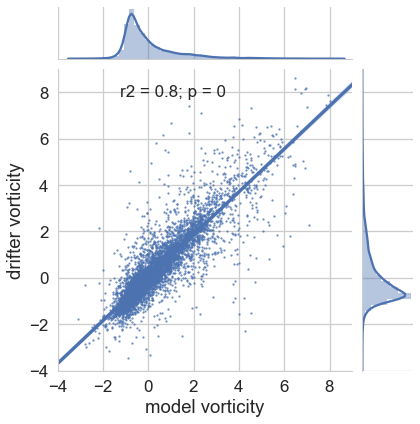

In [45]:
# model vs true
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2,stats.pearsonr(x, y)[1]
g=sns.jointplot(x='model_zeta',y='drifter_zeta',data=df_comparison,
              kind='reg',stat_func=r2,scatter_kws={"s": 5})
plt.xlabel('model vorticity')
plt.ylabel('drifter vorticity')

g.ax_joint.set_xticks([-4,-2,0,2,4,6,8])
g.ax_joint.set_xlim([-4,9])
g.ax_joint.set_ylim([-4,9])
#g.ax_joint.set_yticks([-2,-1,0,1,2,3,4,5])
plt.savefig('performance.pdf',bb_inches='tight',dpi=600)
plt.show()

In [10]:
from scipy.ndimage import gaussian_filter

/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [93]:
mode ='constant'
vor_5km = gaussian_filter(vor,sigma=1,mode=mode)
u_5km = gaussian_filter(u,sigma=1,mode=mode)
v_5km = gaussian_filter(v,sigma=1,mode=mode)
vor_10km = gaussian_filter(vor,sigma=2,mode=mode)
u_10km = gaussian_filter(u,sigma=2,mode=mode)
v_10km = gaussian_filter(v,sigma=2,mode=mode)

In [119]:
vorhat,bin_cents = spec2d(vor,logspacing=True,return_freqs=True,binsize=12)
vor5hat,bin_cents = spec2d(vor_5km,logspacing=True,return_freqs=True,binsize=12)
vor10hat,bin_cents = spec2d(vor_10km,logspacing=True,return_freqs=True,binsize=12)

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interp

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


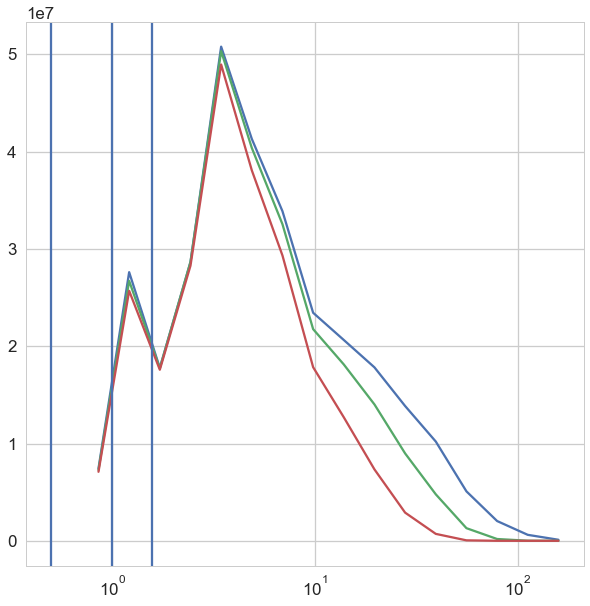

In [120]:
f,ax=plt.subplots(1,1,figsize=(10,10))

vorhat[vorhat<1e1]=np.nan
vor5hat[vor5hat<1e1]=np.nan
vor10hat[vor10hat<1e1]=np.nan

ax.plot(bin_cents,bin_cents*vorhat,label='1km')
ax.plot(bin_cents,bin_cents*vor5hat,label='5km')
ax.plot(bin_cents,bin_cents*vor10hat,label='10km')

ax.axvline(1/1 )
ax.axvline(1/2 )
ax.axvline(2*np.pi/4 )
ax.set_xscale('log',basex=10)


plt.show()

In [31]:
1/bin_cents

array([174.78571467, 146.02275369, 121.99306239, 101.91772785,
        85.14601607,  71.13427865,  59.42833068,  49.6487285 ,
        41.47847017,  34.65272001,  28.95022404,  24.18613811,
        20.20603626,  16.88090506,  14.10296171,  11.78216027,
         9.8432729 ,   8.22345131,   6.87018963,   5.73962243,
         4.79510281,   4.00601455,   3.34677967,   2.79602932,
         2.33591116,   1.95151063,   1.63036754,   1.36207217])

In [197]:
fu = interpolate.RectBivariateSpline(yc,xc,u)
fv = interpolate.RectBivariateSpline(yc,xc,v)
fzeta = interpolate.RectBivariateSpline(yc,xc,vor)
# 10km
fu10 = interpolate.RectBivariateSpline(yc,xc,u_10km)
fv10 = interpolate.RectBivariateSpline(yc,xc,v_10km)
fzeta10 = interpolate.RectBivariateSpline(yc,xc,vor_10km)
# 20km
fu20 = interpolate.RectBivariateSpline(yc,xc,u_20km)
fv20 = interpolate.RectBivariateSpline(yc,xc,v_20km)
fzeta20 = interpolate.RectBivariateSpline(yc,xc,vor_20km)

In [198]:
#%%
ui=np.zeros((N,M))
vi=np.zeros((N,M))
ui10=np.zeros((N,M))
vi10=np.zeros((N,M))
ui20=np.zeros((N,M))
vi20=np.zeros((N,M))
zeta_at_mean = np.zeros(N)
zeta_at_mean10 = np.zeros(N)
zeta_at_mean20 = np.zeros(N)
for i in range(N):
    for j in range(xi[1,:].size):
        ui[i,j] = fu(yi[i,j],xi[i,j])
        vi[i,j] = fv(yi[i,j],xi[i,j])
        ui10[i,j] = fu10(yi[i,j],xi[i,j])
        vi10[i,j] = fv10(yi[i,j],xi[i,j])
        ui20[i,j] = fu20(yi[i,j],xi[i,j])
        vi20[i,j] = fv20(yi[i,j],xi[i,j])
    zeta_at_mean[i]=  fzeta( np.mean(yi[i]),np.mean(xi[i]) )
    zeta_at_mean10[i]=  fzeta10( np.mean(yi[i]),np.mean(xi[i]) )
    zeta_at_mean20[i]=  fzeta20( np.mean(yi[i]),np.mean(xi[i]) )

In [199]:
vort_drifters=np.zeros(N)
vort_drifters10=np.zeros(N)
vort_drifters20=np.zeros(N)
for i in range(N):
    vort_drifters[i],_,_=least_square_method(xi[i,:],yi[i,:],ui[i,:],vi[i,:],2)
    vort_drifters10[i],_,_=least_square_method(xi[i,:],yi[i,:],ui10[i,:],vi10[i,:],2)
    vort_drifters20[i],_,_=least_square_method(xi[i,:],yi[i,:],ui20[i,:],vi20[i,:],2)

In [179]:
df_comparison = pd.DataFrame({'model_zeta':zeta_at_mean,'drifter_zeta':vort_drifters,
                             'model_zeta10':zeta_at_mean10,'drifter_zeta10':vort_drifters10,
                             'model_zeta20':zeta_at_mean20,'drifter_zeta20':vort_drifters20},index=np.arange(N) )

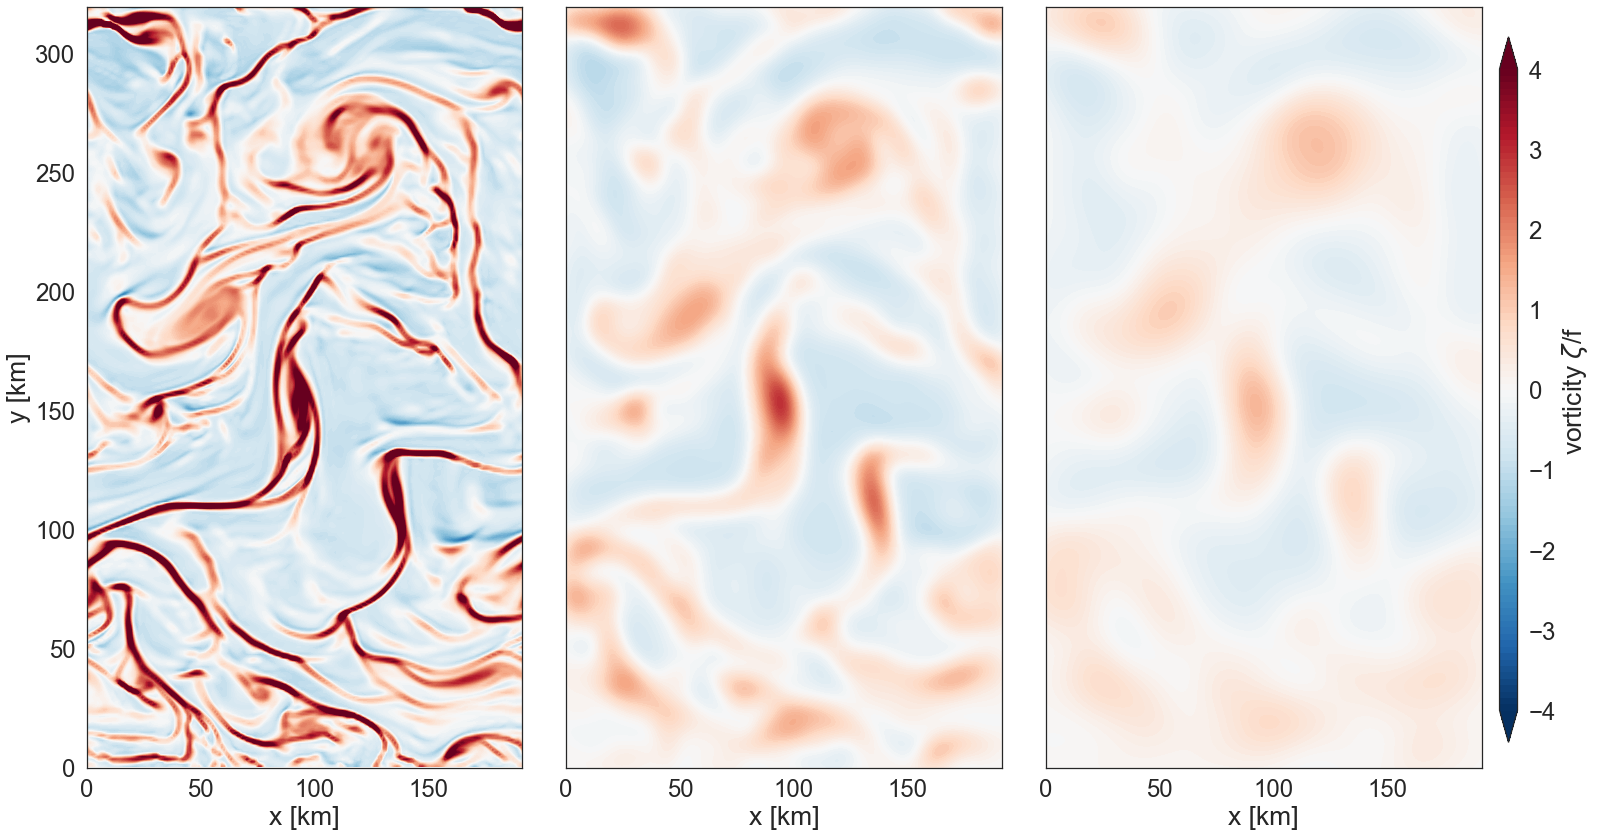

In [258]:
sns.set(context='poster',style='white',font_scale=1.5)
f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(25,14),sharey=True)
vv = np.linspace(-4, 4, 101)
h1=ax1.contourf(xc, yc, vor, vv, extend='both',cmap='RdBu_r', rasterized=True)
h2=ax2.contourf(xc, yc, vor_10km, vv, extend='both',cmap='RdBu_r', rasterized=True)
h3=ax3.contourf(xc, yc, vor_20km, vv, extend='both',cmap='RdBu_r', rasterized=True)

a = ax3.get_position()
cbar_ax = f.add_axes([a.bounds[0]+a.bounds[2]+0.01, 0.15, 0.01, 0.7]) #
cbar = f.colorbar(h3, cax=cbar_ax,ticks=np.arange(-4,5),label='vorticity $\zeta$/f')
cbar.ax.set_xticklabels(np.arange(-4,5))



ax1.set_yticks(np.arange(0,305,50))
ax1.set_xticks(np.arange(0,155,50))
ax2.set_xticks(np.arange(0,155,50))
ax3.set_xticks(np.arange(0,155,50))
ax1.set_ylabel('y [km]')
ax1.set_xlabel('x [km]')
ax2.set_xlabel('x [km]')
ax3.set_xlabel('x [km]')

plt.subplots_adjust(wspace=0.1)
plt.savefig('vorticity_filtered.pdf',bb_inches='tight',dpi=600)
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


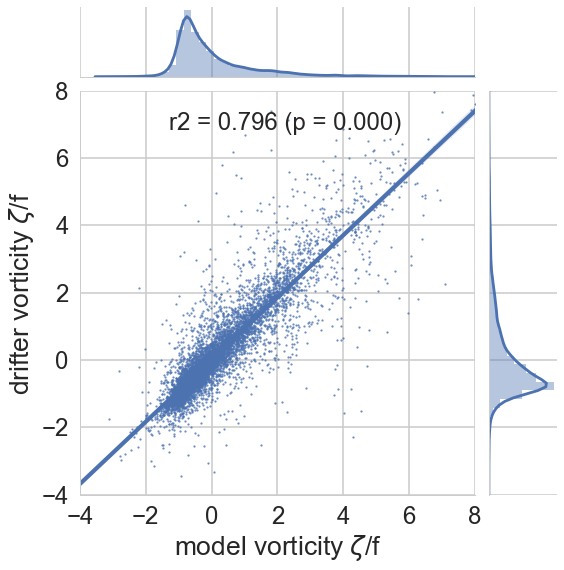

In [263]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2,stats.pearsonr(x, y)[1]
g=sns.jointplot(x='model_zeta',y='drifter_zeta',data=df_comparison,size=8.5,
              kind='reg',stat_func=None,scatter_kws={"s": 5})
g.annotate(r2,template = "{stat} = {val:.3f} (p = {p:.3f})")
plt.xlabel('model vorticity $\zeta$/f')
plt.ylabel('drifter vorticity $\zeta$/f')

g.ax_joint.set_xticks([-4,-2,0,2,4,6,8])
g.ax_joint.set_xlim([-4,8])
g.ax_joint.set_ylim([-4,8])
#g.ax_joint.set_yticks([-2,-1,0,1,2,3,4,5])
plt.savefig('performance_1km.pdf',bb_inches='tight',dpi=400)
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


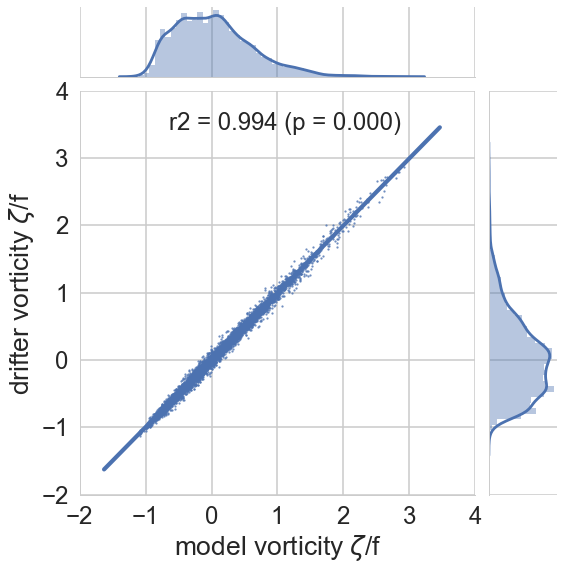

In [264]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2,stats.pearsonr(x, y)[1]
g=sns.jointplot(x='model_zeta10',y='drifter_zeta10',data=df_comparison,size=8.5,
              kind='reg',stat_func=None,scatter_kws={"s": 5})
g.annotate(r2,template = "{stat} = {val:.3f} (p = {p:.3f})")
plt.xlabel('model vorticity $\zeta$/f')
plt.ylabel('drifter vorticity $\zeta$/f')

g.ax_joint.set_xticks([-2,-1,0,1,2,3,4])
g.ax_joint.set_xlim([-2,4])
g.ax_joint.set_ylim([-2,4])
#g.ax_joint.set_yticks([-2,-1,0,1,2,3,4,5])
plt.savefig('performance_5km.pdf',bb_inches='tight',dpi=400)
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


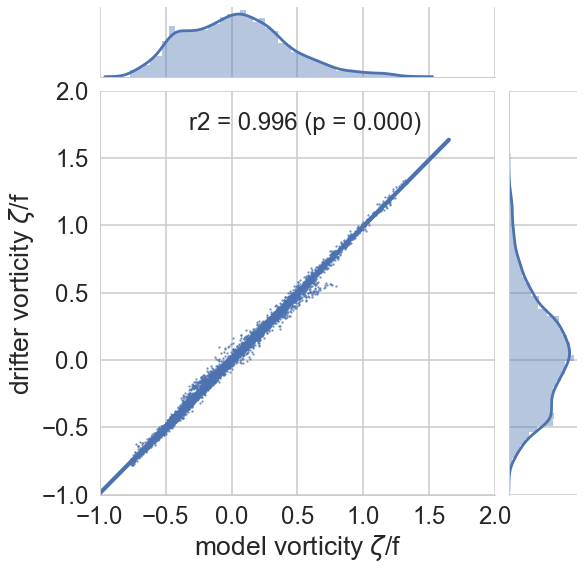

In [265]:
sns.set(context='poster',style='whitegrid',font_scale=1.5)
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2,stats.pearsonr(x, y)[1]
g=sns.jointplot(x='model_zeta20',y='drifter_zeta20',data=df_comparison,size=8.5,
              kind='reg',stat_func=None,scatter_kws={"s": 5})

g.annotate(r2,template = "{stat} = {val:.3f} (p = {p:.3f})")
plt.xlabel('model vorticity $\zeta$/f')
plt.ylabel('drifter vorticity $\zeta$/f')

g.ax_joint.set_xticks([-1,-0.5,0,0.5,1,1.5,2])
g.ax_joint.set_xlim([-1,2])
g.ax_joint.set_ylim([-1,2])
#g.ax_joint.set_yticks([-2,-1,0,1,2,3,4,5])
plt.savefig('performance_10km.pdf',bb_inches='tight',dpi=400)
plt.show()